In [2]:
import torch
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random 

C:\Users\admin\anaconda3\envs\ocr_engine\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\admin\anaconda3\envs\ocr_engine\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def index_classes(items):
    idx = {}
    for i in items:
        if (i not in idx):
            idx[i] = len(idx)
    return idx

class MiniImagenet(data.Dataset):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/datasets/mini_imagenet.py)
    **Description**
    The *mini*-ImageNet dataset was originally introduced by Vinyals et al., 2016.
    It consists of 60'000 colour images of sizes 84x84 pixels.
    The dataset is divided in 3 splits of 64 training, 16 validation, and 20 testing classes each containing 600 examples.
    The classes are sampled from the ImageNet dataset, and we use the splits from Ravi & Larochelle, 2017.
    **References**
    1. Vinyals et al. 2016. “Matching Networks for One Shot Learning.” NeurIPS.
    2. Ravi and Larochelle. 2017. “Optimization as a Model for Few-Shot Learning.” ICLR.
    **Arguments**
    * **root** (str) - Path to download the data.
    * **mode** (str, *optional*, default='train') - Which split to use.
        Must be 'train', 'validation', or 'test'.
    * **transform** (Transform, *optional*, default=None) - Input pre-processing.
    * **target_transform** (Transform, *optional*, default=None) - Target pre-processing.
    * **download** (bool, *optional*, default=False) - Download the dataset if it's not available.
    **Example**
    ~~~python
    ~~~
    """
    def __init__(
        self,
        root,
        mode='train',
        transform=None,
        target_transform=None):
        super(MiniImagenet, self).__init__()
        self.root = os.path.expanduser(root)
        if not os.path.exists(self.root):
            os.mkdir(self.root)
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        pickle_file = os.path.join(self.root, 'mini-imagenet-cache-' + mode + '.pkl')

        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)

   #     self.x = torch.from_numpy(self.data["image_data"]).permute(0, 3, 1, 2).float()
        self.x =self.data["image_data"]
        self.y = np.ones(len(self.x))

        # TODO Remove index_classes from here
        self.class_idx = index_classes(self.data['class_dict'].keys())
        for class_name, idxs in self.data['class_dict'].items():
            for idx in idxs:
                self.y[idx] = self.class_idx[class_name]

    def __getitem__(self, idx):
        data = self.x[idx]
        if self.transform:
            data = self.transform(data)
        return data, self.y[idx]

    def __len__(self):
        return len(self.x)


In [4]:
import math
import torch.nn as nn
from kernel import CannyFilter,get_thin_kernels,get_gaussian_kernel

ModuleNotFoundError: No module named 'cv2'

In [5]:
transform=T.Compose([T.ToTensor(),T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
transform=T.Compose([T.ToTensor()])

train_set=MiniImagenet(root="D:/Dataset/Mini-ImageNet",mode='train',transform=transform)
torch.manual_seed(0)
train_set, val_set = torch.utils.data.random_split(train_set, [30000, 8400])


In [11]:
train_set.target()

AttributeError: 

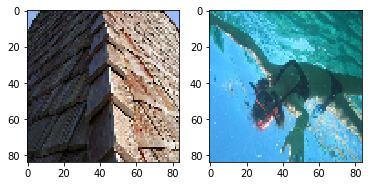

In [21]:
img1=train_set[16][0]
img2=train_set[15][0]
fig,ax=plt.subplots(1,2)
ax[0].imshow(T.ToPILImage()(img1))
ax[1].imshow(T.ToPILImage()(img2))

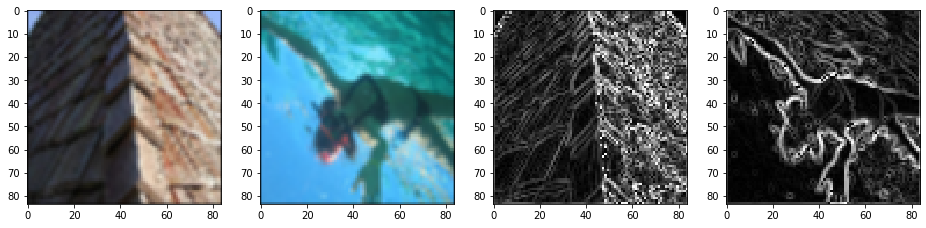

In [22]:


blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)


fig,ax=plt.subplots(1,4,figsize=(16,4))
edged_img1=edge_kernel(img1.unsqueeze(0))[1][0].expand(3,-1,-1)
edged_img2=edge_kernel(img2.unsqueeze(0))[1][0].expand(3,-1,-1)
blured_img1=blur_kernel(img1.unsqueeze(0))[0]
blured_img2=blur_kernel(img2.unsqueeze(0))[0]
ax[0].imshow(T.ToPILImage()(blured_img1))
ax[1].imshow(T.ToPILImage()(blured_img2))

ax[2].imshow(T.ToPILImage()(edged_img1))
ax[3].imshow(T.ToPILImage()(edged_img2))
            

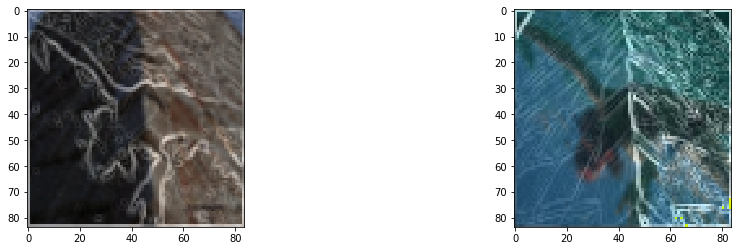

In [23]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
ax[0].imshow(T.ToPILImage()(blured_img1*0.45+edged_img2*0.45))
ax[1].imshow(T.ToPILImage()(blured_img2*0.45+edged_img1*0.45))

In [25]:
train_dl = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=84,
                                          shuffle=True,
                                          drop_last=True)
valid_dl = torch.utils.data.DataLoader(dataset=val_set,
                                          batch_size=84,
                                          shuffle=False,
                                          drop_last=True)

In [40]:
def mix_freq(img,label,b_kernel,e_kernel,lamB=0.5,lamE=0.5):
    with torch.no_grad():
        blured_img=b_kernel(img)
       # edged_img=img-blured_img
        edged_img=e_kernel(img)[1].expand(-1,3,-1,-1)
    idx = torch.randperm(blured_img.shape[0])
    edged_img=edged_img[idx]
    y_b,y_e=label,label[idx]
    mixed_img=lamB*blured_img+lamE*edged_img#+0.2*img

    return mixed_img,y_b,y_e
def mixfreq_criterion(criterion, pred, y_a, y_):
    return  criterion(pred, y_a) + criterion(pred, y_b)

In [41]:
def mix_freq_enhanced(img,label,e_kernel,alpha=1):
    lam=np.random.beta(alpha,alpha)
    with torch.no_grad():
        edged_img=e_kernel(img)[1].expand(-1,3,-1,-1)
    idx = torch.randperm(img.shape[0])
    edged_img=edged_img[idx]
    y_a,y_e=label,label[idx]
    mixed_img=lam*img+(1-lam)*edged_img
    ##+0.2*img
    return mixed_img,y_a,y_e,lam


def mixfreq_criterion_enhanced(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def mix_freq_cycle(img,label,e_kernel,epoch):
    with torch.no_grad():
        edged_img=e_kernel(img)[1].expand(-1,3,-1,-1)
        
    lam=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    
    lam=lam[epoch%11]
    idx = torch.randperm(img.shape[0])
    edged_img=edged_img[idx]
    y_a,y_e=label,label[idx]
    mixed_img=lam*img+(1-lam)*edged_img
    ##+0.2*img
    return mixed_img,y_a,y_e,lam

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def mix_freq_enhanced_classic(img,label,b_kernel,alpha=1):
    lam=np.random.beta(alpha,alpha)
    with torch.no_grad():
        edged_img=img-b_kernel(img)
    idx = torch.randperm(img.shape[0])
    edged_img=edged_img[idx]
    y_a,y_e=label,label[idx]
    mixed_img=lam*img+(1-lam)*edged_img
    ##+0.2*img
    return mixed_img,y_a,y_e,lam




In [42]:
import wandb

In [43]:
img,label=next(iter(train_dl))
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)
blured_img=blur_kernel(img)
#plt.figure()
#plt.imshow(T.ToPILImage()(blured_img[0]))
edged_img=edge_kernel(img)[1].expand(-1,3,-1,-1)
idx = torch.randperm(blured_img.shape[0])
img=img[idx]
blured_img=blured_img[idx]
#plt.figure()
#plt.imshow(T.ToPILImage()(blured_img[0]))
y_a,y_b=label,label[idx]
mixed_img=0.45*blured_img+0.45*edged_img#+0.2*img

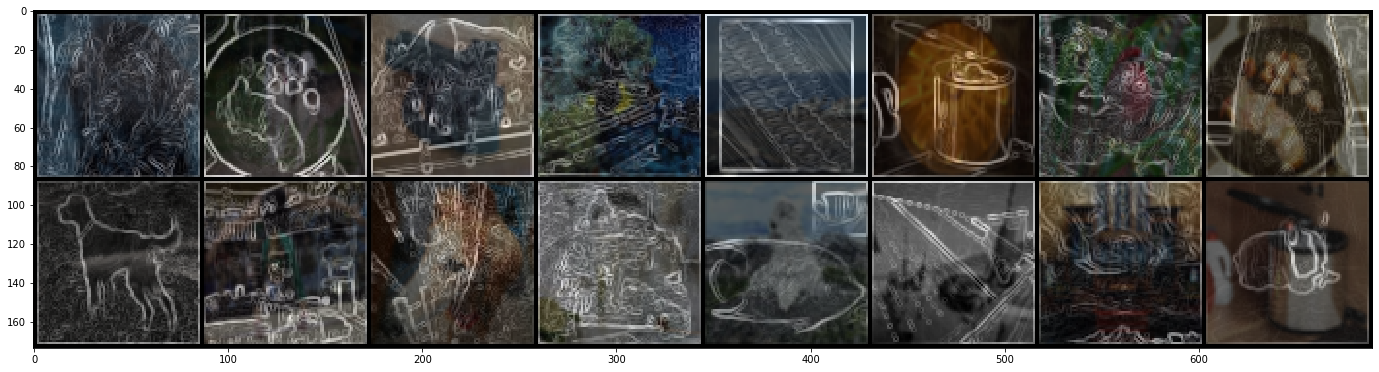

In [44]:
import torchvision
grid_img = torchvision.utils.make_grid(mixed_img[0:16].detach(), nrow=8,normalize=True)

#gt=[label_name[x.long()] for x in LABELS]
plt.figure(figsize=(24,16))
#plt.title(gt)
plt.imshow(grid_img.permute(1, 2, 0))

In [45]:
import torchvision.models as models
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)
model = models.resnet18(num_classes=64)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=1e-4)
device='cuda'

In [46]:
device='cuda'

In [ ]:
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True,use_cuda=True)
blur_kernel.to(device)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False,use_cuda=True)
edge_kernel.to(device)

model.to(device)

wandb.init(project="Augmentation_Strategy")
wandb.run.name = "MixFreq_100epoch_after60_EQUAL1214_CLASSIC"
wandb.run.save()
max_val_accuracy=0
for epoch in tqdm(range(100),leave=False):
    print(f'Epochs : {epoch+1}')
    model.train()
    avg_train_loss=0
    correct=0
    total=0
    for batch_idx,(img,label) in enumerate(train_dl):
        #Zero_grad_Optimizer
        optimizer.zero_grad()
        img=img.to(device)
        label=label.to(device).long()
        if epoch<60:
            img,labelA,labelB=mix_freq(img,label,b_kernel=blur_kernel,e_kernel=edge_kernel)
            output=model(img)
            loss=mixfreq_criterion(criterion,output,labelA,labelB)
            #Measure Loss
            loss.backward()
        else:
            output=model(img)
            loss=criterion(output,label)
            loss.backward()
            

        #Update Parameters
        optimizer.step()
        avg_train_loss+=loss.item()
        if batch_idx % 50==0:
            wandb.log({
                "Train Loss": avg_train_loss/(batch_idx+1)})
    model.eval()
    valid_loss=0
    correct=0
    total=0

    for batch_idx,(img,label) in enumerate(valid_dl):

        img=img.to(device)
        label=label.to(device).long()

        output=model(img)
        #Measure Loss
        loss=criterion(output,label)
        valid_loss+=loss.item()

        _, predicted = torch.max(output.data, 1)
        total+=label.size()[0]
        correct += (predicted == label).sum().item()
    avg_valid_loss=valid_loss/(len(valid_dl))
    wandb.log({
        "epoch": epoch,
        "Val Accuracy": correct/total,
        "Val Loss": avg_valid_loss})
    if (correct/total)>max_val_accuracy:
        max_val_accuracy=correct/total
        print('Validation Result is better, saving the new model')
        torch.save(model.state_dict(),"models/mix_freq_classic_EQUAL_classic.h")


Train Loss,██▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
Val Accuracy,▁▁▂▂▂▃▃▃▃▃▄▄▃▄▃▄▄▄▄▄▃▄▄▄████████▆▇▇▆▇▇▇▇
Val Loss,█▆█▆▅▄▅▄▄▄▄▄▅▄▅▄▄▄▄▄▅▄▄▄▂▁▁▁▁▁▁▁▁▂▄▄▃▃▄▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,0.11992
Val Accuracy,0.37869
Val Loss,3.48462
epoch,99


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epochs : 1
Validation Result is better, saving the new model


  1%|▊                                                                                 | 1/100 [00:33<54:53, 33.27s/it]

Epochs : 2


  2%|█▋                                                                                | 2/100 [01:06<54:13, 33.20s/it]

Validation Result is better, saving the new model
Epochs : 3


  3%|██▍                                                                               | 3/100 [01:39<53:33, 33.13s/it]

Epochs : 4


  4%|███▎                                                                              | 4/100 [02:12<53:11, 33.25s/it]

Validation Result is better, saving the new model
Epochs : 5


  5%|████                                                                              | 5/100 [02:46<52:42, 33.29s/it]

Validation Result is better, saving the new model
Epochs : 6


  6%|████▉                                                                             | 6/100 [03:19<51:56, 33.15s/it]

Epochs : 7


  7%|█████▋                                                                            | 7/100 [03:51<51:12, 33.04s/it]

Epochs : 8


  8%|██████▌                                                                           | 8/100 [04:24<50:41, 33.06s/it]

Epochs : 9


  9%|███████▍                                                                          | 9/100 [04:57<49:52, 32.88s/it]

Epochs : 10


 10%|████████                                                                         | 10/100 [05:30<49:12, 32.81s/it]

Epochs : 11


 11%|████████▉                                                                        | 11/100 [06:02<48:41, 32.82s/it]

Epochs : 12
